In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from lab7_cmd_types import CMD
import time
import numpy as np
LOG.propagate = False
import matplotlib.pyplot as plt


In [168]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-24 00:30:13,627 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64
2025-03-24 00:30:17,026 | INFO     |: Connected to c0:81:04:26:a3:64


In [22]:
ble.disconnect()

2025-03-23 22:29:16,089 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [160]:
ble.send_command(CMD.PING, "")
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [179]:
ble.send_command(CMD.START_STEP, "")

In [23]:
ble.send_command(CMD.STOP_STEP, "")

In [180]:
results = []


def notification_handler(uuid, byte_array):
    # Parse the data string from Arduino
    # Format: time | distance | velocity
    time_val, pwm, distance_val, velocity_val = ble.bytearray_to_string(
        byte_array).split('|')

    # Convert to appropriate types and store
    results.append([float(time_val), int(pwm), float(distance_val), float(velocity_val)])


# ble.stop_notify(ble.uuid['RX_STRING'])  # Optional: stop previous notifications
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.COLLECT_DATA, "")

In [178]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [28]:
import csv
import datetime

# Generate filename with timestamp to avoid overwriting
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"robot_data_{timestamp}.csv"

with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write header
    csvwriter.writerow(['Time (ms)', 'Distance (mm)', 'Velocity (mm/s)'])
    # Write all data rows
    csvwriter.writerows(results)

print(f"Data saved to {filename}")

Data saved to robot_data_20250323_223015.csv


In [195]:
## Load results from csv file
import pandas as pd
df = pd.read_csv('robot_data_20250323_223015.csv')
results = df.values
print(results.shape)

## Fit the data

(55, 4)


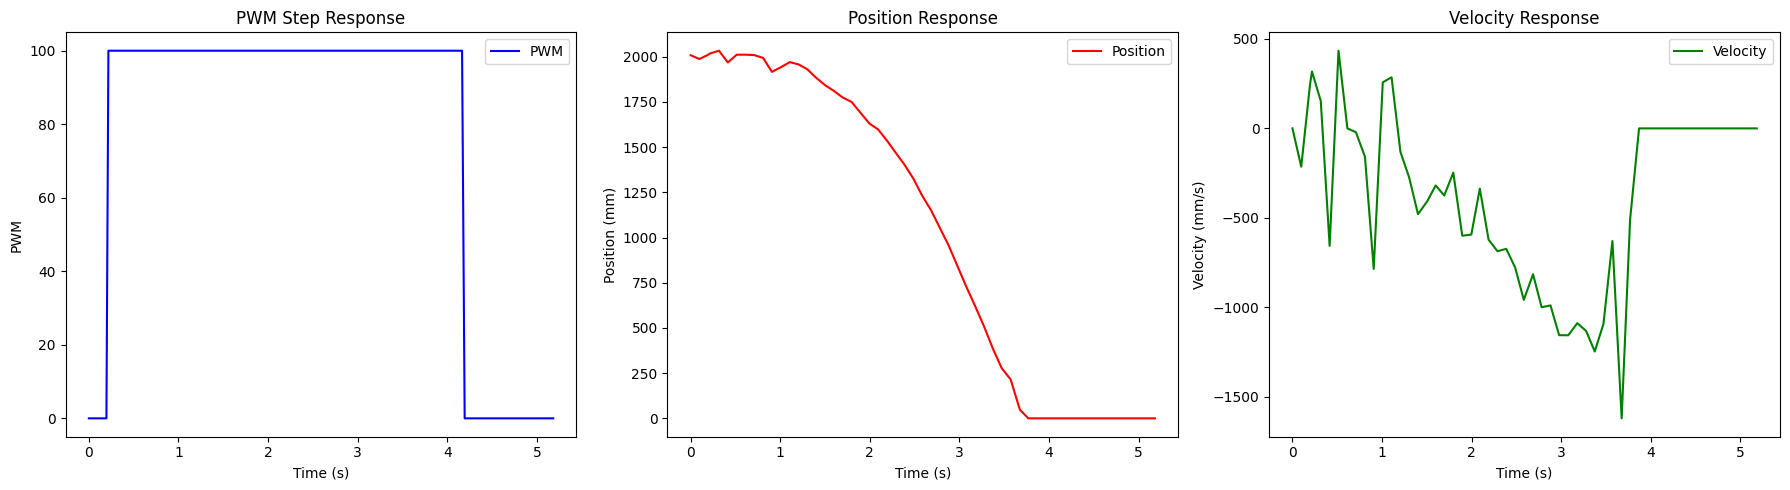

In [227]:
# Now create the plots
# Convert results to numpy array for easier handling
data = np.array(results)
time_ms = data[:, 0]
pwm = data[:, 1]
distance = data[:, 2]
velocity = data[:, 3]

# Convert time to seconds
# Normalize to start at 0 and convert to seconds
time_s = (time_ms - time_ms[0]) / 1000.0

# Create figure with three subplots in a row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot PWM vs Time
ax1.plot(time_s, pwm, 'b-', label='PWM')
ax1.set_ylabel('PWM')
ax1.set_xlabel('Time (s)')
ax1.set_title('PWM Step Response')
ax1.legend()

# Plot Position (Distance) vs Time
ax2.plot(time_s, distance, 'r-', label='Position')
ax2.set_ylabel('Position (mm)')
ax2.set_xlabel('Time (s)')
ax2.set_title('Position Response')
ax2.legend()

# Plot Velocity vs Time
ax3.plot(time_s, velocity, 'g-', label='Velocity')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity (mm/s)')
ax3.set_title('Velocity Response')
ax3.legend()

plt.tight_layout()
plt.show()

Fitted equation: v(t) = -2053.62 * (1 - e^(-0.15t))


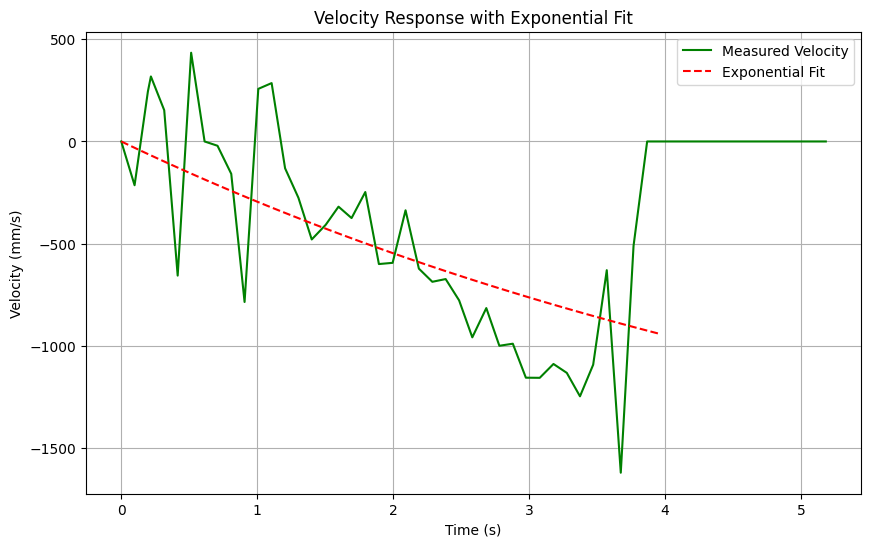

In [228]:
from scipy.optimize import curve_fit
def exp_decay(x, A, b): 
    return A * (1 - np.exp(-b * x))

x_data = np.array(time_s[:42]) # cropped data
y_data = np.array(velocity[:42]) # cropped data

params, covariance = curve_fit(exp_decay, x_data, y_data, p0=(-1500, 3))
A_fit, b_fit = params

# Generate points for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = exp_decay(x_fit, A_fit, b_fit)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_s, velocity, 'g-', label='Measured Velocity')
plt.plot(x_fit, y_fit, 'r--', label='Exponential Fit')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (mm/s)')
plt.title('Velocity Response with Exponential Fit')
plt.grid(True)
plt.legend()

# Print the fitted equation
print(f'Fitted equation: v(t) = {A_fit:.2f} * (1 - e^(-{b_fit:.2f}t))')

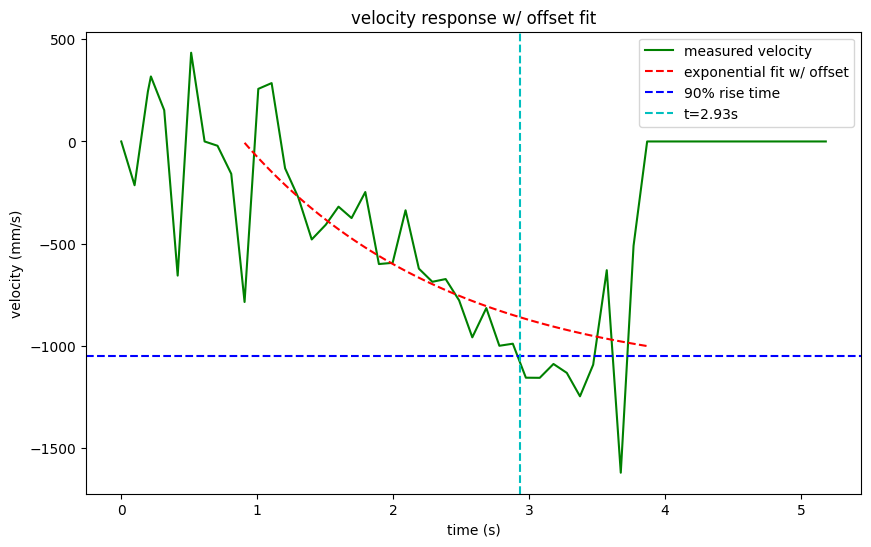

fitted eqn: v(t) = 936.30 + -2104.71 * (1 - e^(-0.66*t))


In [240]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def exp_decay_offset(x, a, b, c):
    return c + a * (1 - np.exp(-b * x))


# assume time_s and velocity are numpy arrays
x_data = time_s[10:41]
y_data = velocity[10:41]

# initial guess
p0 = (-1500, 3, 0)

params, covariance = curve_fit(exp_decay_offset, x_data, y_data, p0=p0)
a_fit, b_fit, c_fit = params

# generate points for fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = exp_decay_offset(x_fit, a_fit, b_fit, c_fit)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(time_s, velocity, 'g-', label='measured velocity')
plt.plot(x_fit, y_fit, 'r--', label='exponential fit w/ offset')
plt.xlabel('time (s)')
plt.ylabel('velocity (mm/s)')
plt.title('velocity response w/ offset fit')
plt.axhline(y=-1051.569, color='b', linestyle='--', label='90% rise time')
plt.axvline(x=2.93, color='c', linestyle='--', label='t=2.93s')
# plt.grid(True)
plt.legend()
plt.show()

print(
    f'fitted eqn: v(t) = {c_fit:.2f} + {a_fit:.2f} * (1 - e^(-{b_fit:.2f}*t))')

In [316]:
# sampling time
dt = time_s[1] - time_s[0]
print(f"Sampling time: {dt:.4f} s")

Sampling time: 0.0980 s


In [317]:
# State space
d = 0.000856
m = 0.00109
A = np.array([[0, 1], [0, -(d / m)]])
B = np.array([[0], [1 / m]])
C = np.array([[1, 0]])
n = 2

# Discretize the system
Ad = np.eye(n) + (dt * A)
Bd = dt*B

In [318]:
# State Vector
X = np.array([[distance[0]], [0]])
sigma_1 = sigma_2 = 31.94
sigma_3 = 20
sig_u = np.array([[sigma_1**2,0],[0,sigma_2**2]])
sig_z = np.array([[sigma_3**2]])

In [319]:
def kf (mu, sigma, u, y):
    mu_p = Ad.dot(mu) + Bd.dot(u)
    sigma_p = Ad.dot(sigma.dot(Ad.transpose())) + sig_u
    
    
    sigma_m = C.dot(sigma_p.dot(C.transpose())) + sig_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))
    
    y_m = y-C.dot(mu_p)
    mu = mu_p + kkf_gain.dot(y_m)
    sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)
    
    return mu, sigma
    

In [320]:
kfs = []
uss = [1 if i==100.0 else 0 for i in pwm]
kfs.append(distance[0])
# initial state uncertainty
sigma = np.array([[20**2, 0], [0, 10**2]])
for i in range(1, len(time_s)):
    X, sigma = kf(X, sigma, uss[i], distance[i])
    kfs.append(X[0][0])

In [321]:
print(kfs)

[np.float64(2008.0), np.float64(1991.6125359942541), np.float64(2006.549230175089), np.float64(2015.408490764009), np.float64(2031.0580237766117), np.float64(1986.1234245309847), np.float64(2010.6226389590497), np.float64(2017.6864426818263), np.float64(2018.9696494328732), np.float64(2007.872464169132), np.float64(1946.3302220629068), np.float64(1953.1609680684035), np.float64(1977.2861266511504), np.float64(1973.3806749001933), np.float64(1951.9995186715846), np.float64(1910.9461531217403), np.float64(1869.211600529585), np.float64(1836.654380889742), np.float64(1801.529725287034), np.float64(1774.3654725539573), np.float64(1721.7581318824143), np.float64(1663.2696186272367), np.float64(1625.2528929754649), np.float64(1569.3777167380672), np.float64(1503.9275760964924), np.float64(1437.8441899113602), np.float64(1363.068499599358), np.float64(1273.8461698127824), np.float64(1188.3369645060175), np.float64(1094.3759702504667), np.float64(996.9426852690497), np.float64(888.619563832079

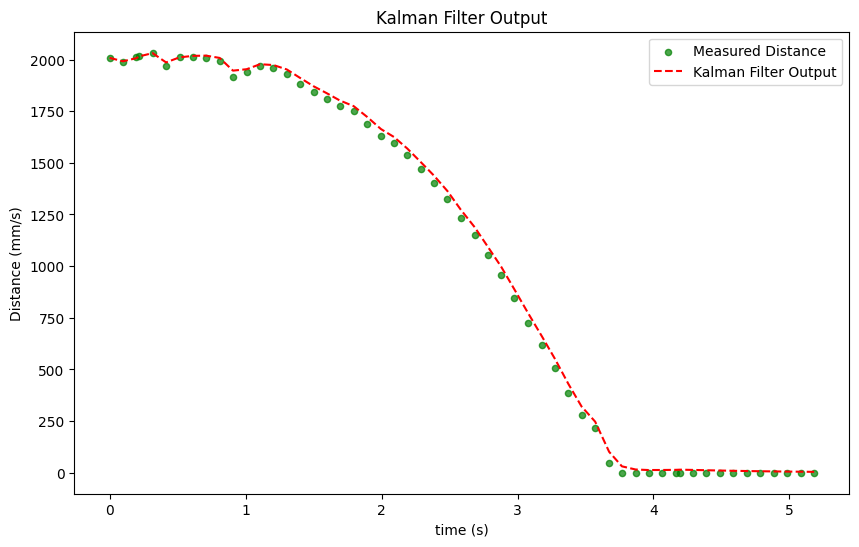

In [322]:
# Plots the distance data and kalman filter output
plt.figure(figsize=(10, 6))
plt.scatter(time_s, distance, color='g', s=20, marker='o',
            alpha=0.7, label='Measured Distance')

# plt.plot(time_s, distance, 'g-', label='Measured Distance')
plt.plot(time_s, kfs, 'r--', label='Kalman Filter Output')
plt.xlabel('time (s)')
plt.ylabel('Distance (mm/s)')
plt.title('Kalman Filter Output')
plt.legend()
plt.show()